## Import packages

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
import statsmodels.stats.multicomp as mc

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA 
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore, ttest_rel, ttest_1samp, pearsonr, spearmanr, kendalltau, f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.tools.tools import add_constant
import matplotlib as mpl

np.set_printoptions(suppress=True)

mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['axes.spines.top'] = True
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['axes.spines.left'] = True

result_folder = '/home/dasom/SM_DATA/Distributed/files'

## Rating data

In [9]:
sub_names = ['sub-01','sub-02','sub-03','sub-04','sub-05',
             'sub-06','sub-07','sub-08','sub-09','sub-10',
             'sub-11','sub-12','sub-13','sub-14','sub-15',
             'sub-16','sub-17','sub-18','sub-19','sub-20',
             'sub-21','sub-22','sub-23','sub-24','sub-25',
             'sub-26','sub-27','sub-28']

sub_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]
subjN = len(sub_list)
total_edge_DM = np.load(f'{result_folder}/total_edge_DM.npy')
total_personalities = np.load(f'{result_folder}/total_personalities.npy')

## Annotation data

In [10]:
excluded_tr_ep1 = np.concatenate([np.arange(10)])
excluded_tr_ep2 = np.concatenate([np.arange(44)])
excluded_tr_ep3 = np.concatenate([np.arange(44)])

rest_tr_ep1 = np.delete(np.arange(996), excluded_tr_ep1)
rest_tr_ep2 = np.delete(np.arange(958), excluded_tr_ep2)
rest_tr_ep3 = np.delete(np.arange(710), excluded_tr_ep3)
rest_total = rest_tr_ep1.shape[0] + rest_tr_ep2.shape[0] + rest_tr_ep3.shape[0]
rest_tr = np.hstack([rest_tr_ep1, rest_tr_ep2+996, rest_tr_ep3+996+958])
print(f'{rest_tr_ep1.shape[0]} + {rest_tr_ep2.shape[0]} + {rest_tr_ep3.shape[0]} = {rest_total}')

986 + 914 + 666 = 2566


#### Event

In [11]:
sub_event_tag = pd.read_csv(f'{result_folder}/event_segmentation_trim.csv')
overlap_start2 = sub_event_tag.total_start2
overlap_end2 = sub_event_tag.total_end2

#### Detailed annotation

In [12]:
total_cooccur = np.load(f'{result_folder}/TR_cooccur.npy')
total_senti = np.load(f'{result_folder}/TR_senti.npy')
total_senti_pos = np.load(f'{result_folder}/TR_senti_pos.npy')
total_senti_neg = np.load(f'{result_folder}/TR_senti_neg.npy')

## Behavioral modeling

In [13]:
events = np.array([21,45,61])-1

cooccur = []
cooccur_trim = []
for i in range(61):
    cooccur_mat1 = np.mean(total_cooccur[overlap_start2[i]:overlap_end2[i]], axis=0)
    cooccur_mat2 = np.mean(total_cooccur[overlap_start2[i]:overlap_end2[i]], axis=0)
    cooccur_mat1[cooccur_mat1 > 0] = 1
    cooccur_trim.append(cooccur_mat1)
    cooccur.append(cooccur_mat2)
cooccur_trim = np.array(cooccur_trim)
cooccur = np.array(cooccur)

senti = []
senti_pos = []
senti_neg = []
for i in range(61):
    senti_mat = np.mean(total_senti[overlap_start2[i]:overlap_end2[i]], axis=0)
    senti_pos_mat = np.mean(total_senti_pos[overlap_start2[i]:overlap_end2[i]], axis=0)
    senti_neg_mat = np.mean(total_senti_neg[overlap_start2[i]:overlap_end2[i]], axis=0)
    senti.append(senti_mat)
    senti_pos.append(senti_pos_mat)
    senti_neg.append(senti_neg_mat)
senti = np.array(senti)
senti_pos = np.array(senti_pos)
senti_neg = np.array(senti_neg)

scores_pos = np.concatenate([senti_pos[i][senti_pos[i] > 0] for i in range(61)])
scores_neg = np.concatenate([senti_neg[i][senti_neg[i] < 0] for i in range(61)])

thr_pos = np.percentile(scores_pos, 100/3) # 50 100/3
thr_neg = np.percentile(scores_neg, 200/3) # 50 200/3

senti_trim = []
senti_trim_pos = []
senti_trim_neg = []

senti_tmp = senti.copy()
senti_tmp_pos1 = senti_pos.copy()
senti_tmp_neg1 = senti_neg.copy()
for i in range(61):
    senti_tmp[i][(senti_tmp[i]>=thr_neg) & (senti_tmp[i]<=thr_pos)] = 0
    senti_tmp[i][senti_tmp[i]>thr_pos] = 1
    senti_tmp[i][senti_tmp[i]<thr_neg] = -1

    senti_tmp_pos1[i][senti_tmp_pos1[i] > thr_pos] = 1
    senti_tmp_pos1[i][senti_tmp_pos1[i] <= thr_pos] = 0

    senti_tmp_neg1[i][senti_tmp_neg1[i] < thr_neg] = -1
    senti_tmp_neg1[i][senti_tmp_neg1[i] >= thr_neg] = 0

    senti_trim.append(np.nan_to_num(senti_tmp[i]))
    senti_trim_pos.append(senti_tmp_pos1[i])
    senti_trim_neg.append(senti_tmp_neg1[i])
senti_trim_pos = np.array(senti_trim_pos)
senti_trim_neg = np.array(senti_trim_neg)

senti_trim_neutral = cooccur_trim.copy()
for ev in range(61):
    for ch1 in range(6):
        for ch2 in range(6):
            if cooccur_trim[ev][ch1,ch2] == 1:
                if senti_trim_pos[ev][ch1,ch2] != 0 or senti_trim_neg[ev][ch1,ch2] != 0:
                    senti_trim_neutral[ev][ch1,ch2] = 0
senti_cumsum_neutral = np.cumsum(senti_trim_neutral, axis=0)

cooccur_cumsum = np.cumsum(cooccur_trim, axis=0)
senti_cumsum = np.cumsum(senti_trim, axis=0)
senti_cumsum_pos = np.cumsum(senti_trim_pos, axis=0)
senti_cumsum_neg = np.cumsum(senti_trim_neg, axis=0)

### PLS

In [ ]:
# how many latent?
from mbpls.mbpls import MBPLS
run = 2 # +1

cn = 6
aa = np.ones((cn,cn))
aa[np.diag_indices(cn)] = 0
aa = aa.astype('bool')

rs = []
r2s = []
evr_xs = []
evr_ys = []
for s in range(28):
    others = np.delete(np.arange(28), s)

    cooccur_train = np.concatenate([zscore(cooccur_cumsum[events[r]][:cn,:cn][aa], axis = None) for s in others])
    senti_neu_train = np.concatenate([zscore(senti_cumsum_neutral[events[r]][:cn,:cn][aa], axis = None) for s in others])
    senti_pos_train = np.concatenate([zscore(senti_cumsum_pos[events[r]][:cn,:cn][aa], axis = None) for s in others])
    senti_neg_train = np.concatenate([zscore(senti_cumsum_neg[events[r]][:cn,:cn][aa], axis = None) for s in others])

    X_train = [np.array([cooccur_train]).T, np.array([senti_pos_train, senti_neu_train, senti_neg_train]).T]
    Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][r][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

    cooccur_test = zscore(cooccur_cumsum[events[r]][:cn,:cn][aa], axis = None)
    senti_neu_test = zscore(senti_cumsum_neutral[events[r]][:cn,:cn][aa], axis = None)
    senti_pos_test = zscore(senti_cumsum_pos[events[r]][:cn,:cn][aa], axis = None)
    senti_neg_test = zscore(senti_cumsum_neg[events[r]][:cn,:cn][aa], axis = None)

    X_test = [np.array([cooccur_test]).T, np.array([senti_pos_test, senti_neu_test, senti_neg_test]).T]
    Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][r][tp][aa] for tp in range(6)]), axis=1)).T

    max_components = 4
    pls = MBPLS(n_components=max_components)
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)
    
    rs.append([pearsonr(Y_test[:, i], Y_pred[:, i])[0] for i in range(Y_test.shape[1])])
    r2s.append([r2_score(Y_test[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])])
    evr_xs.append(pls.explained_var_xblocks_)
    evr_ys.append(pls.explained_var_y_)

In [27]:
np.mean(evr_xs, axis=0)

array([[0.99398155, 0.00097191, 0.00212026, 0.00292629],
       [0.65972243, 0.28833172, 0.05142408, 0.00052177]])

In [ ]:
cn = 6
aa = np.ones((cn,cn))
aa[np.diag_indices(cn)] = 0
aa = aa.astype('bool')

aics = []
coefs = []
rs = []
r2s = []
latent_reps = []
for s in range(28):
    others = np.delete(np.arange(28), s)

    cooccur_train = np.concatenate([zscore(cooccur_cumsum[-1][:cn,:cn][aa], axis = None) for s in others])
    senti_neu_train = np.concatenate([zscore(senti_cumsum_neutral[-1][:cn,:cn][aa], axis = None) for s in others])
    senti_pos_train = np.concatenate([zscore(senti_cumsum_pos[-1][:cn,:cn][aa], axis = None) for s in others])
    senti_neg_train = np.concatenate([zscore(senti_cumsum_neg[-1][:cn,:cn][aa], axis = None) for s in others])

    cooccur_test = zscore(cooccur_cumsum[-1][:cn,:cn][aa], axis = None)
    senti_neu_test = zscore(senti_cumsum_neutral[-1][:cn,:cn][aa], axis = None)
    senti_pos_test = zscore(senti_cumsum_pos[-1][:cn,:cn][aa], axis = None)
    senti_neg_test = zscore(senti_cumsum_neg[-1][:cn,:cn][aa], axis = None)
    # cooccur_test = np.zeros(30) # ablation
    # senti_neu_test = np.zeros(30) # ablation
    # senti_pos_test = np.zeros(30) # ablation
    # senti_neg_test = np.zeros(30) # ablation

    # X_train = np.array([cooccur_train]).T # single feature subspace
    # X_train = np.array([senti_pos_train, senti_neu_train, senti_neg_train]).T # single feature subspace
    X_train = np.array([cooccur_train, senti_pos_train, senti_neu_train, senti_neg_train]).T
    Y_train = np.hstack([np.nan_to_num(zscore(np.array([total_edge_DM[ss][tp][aa] for tp in range(6)]), axis=1)) for ss in others]).T

    # X_test = np.array([cooccur_test]).T  # single feature subspace
    # X_test = np.array([senti_pos_test, senti_neu_test, senti_neg_test]).T   # single feature subspace
    X_test = np.array([cooccur_test, senti_pos_test, senti_neu_test, senti_neg_test]).T   
    Y_test = np.nan_to_num(zscore(np.array([total_edge_DM[s][tp][aa] for tp in range(6)]), axis=1)).T

    max_components = 3
    pls = PLSRegression(n_components=max_components)
    pls.fit(X_train, Y_train)
    Y_pred = pls.predict(X_test)

    residuals = Y_train - pls.predict(X_train)
    rss = np.sum(residuals**2)
    n = len(Y_train)
    k = X_train.shape[1] * max_components
    aic = n * np.log(rss / n) + 2 * k
    bic = n * np.log(rss / n) + k * np.log(n)

    mean_Y_test = np.mean(Y_test, axis=0) 
    mean_Y_pred = np.mean(Y_pred, axis=0)

    covariance = np.sum((Y_test - mean_Y_test) * (Y_pred - mean_Y_pred), axis=0).sum()  
    std_Y_test = np.sqrt(np.sum((Y_test - mean_Y_test) ** 2, axis=0).sum()) 
    std_Y_pred = np.sqrt(np.sum((Y_pred - mean_Y_pred) ** 2, axis=0).sum()) 
    correlation = covariance / (std_Y_test * std_Y_pred)
    
    aics.append(aic)
    coefs.append(pls.y_weights_)
    rs.append([pearsonr(Y_test[:, i], Y_pred[:, i])[0] for i in range(Y_test.shape[1])])
    r2s.append([r2_score(Y_test[:, i], Y_pred[:, i]) for i in range(Y_test.shape[1])])

    latent_y = Y_test @ pls.y_weights_
    latent_y_mat = np.zeros((max_components,6,6))
    latent_y_mat[:,aa] = latent_y.T
    latent_x = X_test @ pls.x_weights_
    latent_x_mat = np.zeros((max_components,6,6))
    latent_x_mat[:,aa] = latent_x.T
    latent_reps.append(latent_y_mat)
r2s = np.array(r2s)

In [ ]:
np.save(f'{result_folder}/Behavioral_latent_Y_representation.npy', latent_reps)

In [ ]:
# for ablation analysis
# cooccur_drop = r2s
valence_drop = r2s
# full = r2s

In [ ]:
# for unique contribution
# cooccur_only = r2s
valence_only = r2s
# full = r2s

In [20]:
ttest_rel(np.mean(full, axis=1), np.mean(valence_drop, axis=1))

TtestResult(statistic=30.020382172866082, pvalue=2.8073885356823633e-22, df=27)

In [20]:
[ttest_rel(cooccur_drop[:,rel], valence_drop[:,rel]) for rel in range(6)]

[TtestResult(statistic=30.325984800664102, pvalue=2.1519928926507363e-22, df=27),
 TtestResult(statistic=15.557890249951553, pvalue=5.299759031704535e-15, df=27),
 TtestResult(statistic=19.70715387149607, pvalue=1.4801532365533432e-17, df=27),
 TtestResult(statistic=13.985994470653855, pvalue=6.916389153163197e-14, df=27),
 TtestResult(statistic=10.870338330518889, pvalue=2.3007420762404874e-11, df=27),
 TtestResult(statistic=20.92859151097778, pvalue=3.2138785916360437e-18, df=27)]

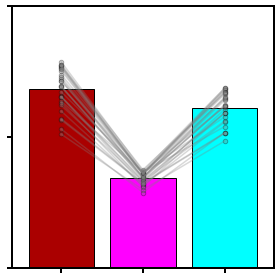

In [ ]:
# Figure 2b
# ablation analysis
data0 = np.mean(r2s, axis = 1)
data1 = np.mean(valence_drop, axis = 1)
data2 = np.mean(cooccur_drop, axis = 1)

fig = plt.figure(figsize = [4,4])
barlist = plt.bar([0,1,2], np.mean([data0, data1, data2], axis=1), color = 'grey')

for i in range(3):
    barlist[i].set_edgecolor('#000000') 
barlist[0].set_facecolor('#aa0000')
barlist[1].set_facecolor('#ff00ff')
barlist[2].set_facecolor('#00ffff')

plt.plot(np.array([data0, data1, data2]), color = 'gray', alpha = 0.3)
plt.scatter(np.zeros(28),data0, s=20, color = 'gray', edgecolor = 'k', alpha = 0.3)
plt.scatter(np.ones(28),data1, s=20, color = 'gray', edgecolor = 'k', alpha = 0.3)
plt.scatter(np.ones(28)*2,data2, s=20, color = 'gray', edgecolor = 'k', alpha = 0.3)
plt.xticks([0,1,2],[])
plt.yticks([0.,0.5,1.0],[])
# plt.ylim([0.4,1])
plt.xlim([-0.6,2.6])
fig.tight_layout()

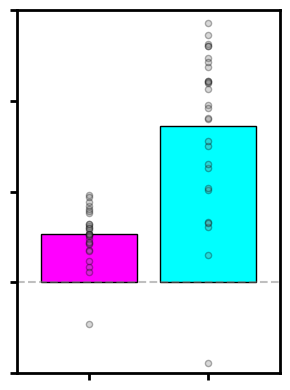

In [ ]:
# Figure 2b
# unique contribution
data1 = np.mean(np.array(full)-np.array(valence_only), axis = 1)
data2 = np.mean(np.array(full)-np.array(co_occur_only), axis = 1)

fig = plt.figure(figsize = [3,4])
barlist = plt.bar([0,1], np.mean([data1, data2], axis=1), color = 'grey')

for i in range(2):
    barlist[i].set_edgecolor('#000000') 
barlist[0].set_facecolor('#ff00ff')
barlist[1].set_facecolor('#00ffff')

# plt.plot(np.array([data1, data2]), color = 'gray', alpha = 0.3)
plt.scatter(np.ones(28)*0,data1, s=20, color = 'gray', edgecolor = 'k', alpha = 0.3)
plt.scatter(np.ones(28),data2, s=20, color = 'gray', edgecolor = 'k', alpha = 0.3)
plt.xticks([0,1],[])
plt.yticks([-0.05,0.,0.05,0.1,0.15],[])
plt.ylim([-.05,0.15])
plt.hlines(0,-0.6,1.6,color = 'grey', linestyle = '--', alpha = 0.5)
plt.xlim([-0.6,1.6])
fig.tight_layout()

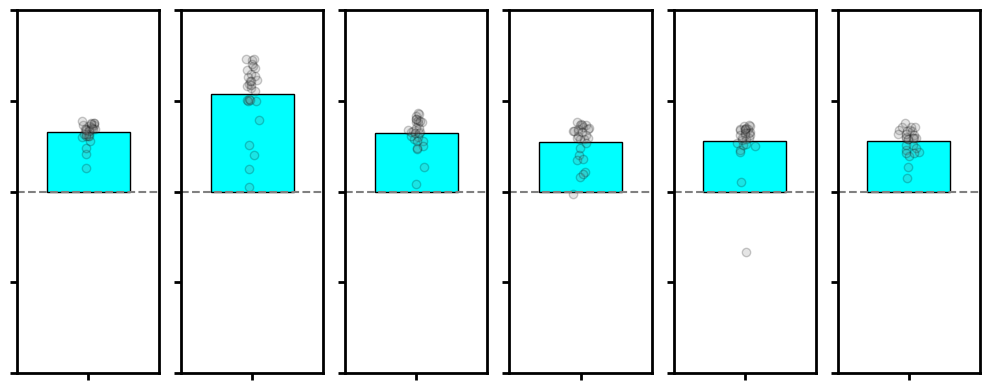

In [ ]:
# Extended Data Figure 2a
fig = plt.figure(figsize = [10,4])
for rel in range(6):
    axs = fig.add_subplot(1,6,rel+1)
    
    difference = cooccur_drop[:,rel] - valence_drop[:,rel]
    axs.bar(0, np.mean(difference), color = 'cyan', edgecolor = 'k', width = 0.7)
    axs.scatter(np.random.normal(size = 28)/30 + 0, difference, 
                color = 'gray', alpha = 0.2, edgecolor= 'k', zorder = 2)

    axs.set_xlim([-0.6,0.6])
    if rel == 1:
        axs.set_ylim([-0.8,0.8])
        axs.set_yticks([-0.8,-0.4,0,0.4,0.8])
    # elif rel == 3 or rel == 5:
    #     axs.set_ylim([-0.2,0.2])
    #     axs.set_yticks([-0.2,-0.1,0,0.1,0.2])
    else:
        axs.set_ylim([-0.8,0.8])
        axs.set_yticks([-0.8,-0.4,0,0.4,0.8])
    axs.set_xticks([0])
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    axs.hlines(0, -0.6, 0.6, linestyle = '--', color = 'grey')
fig.tight_layout()

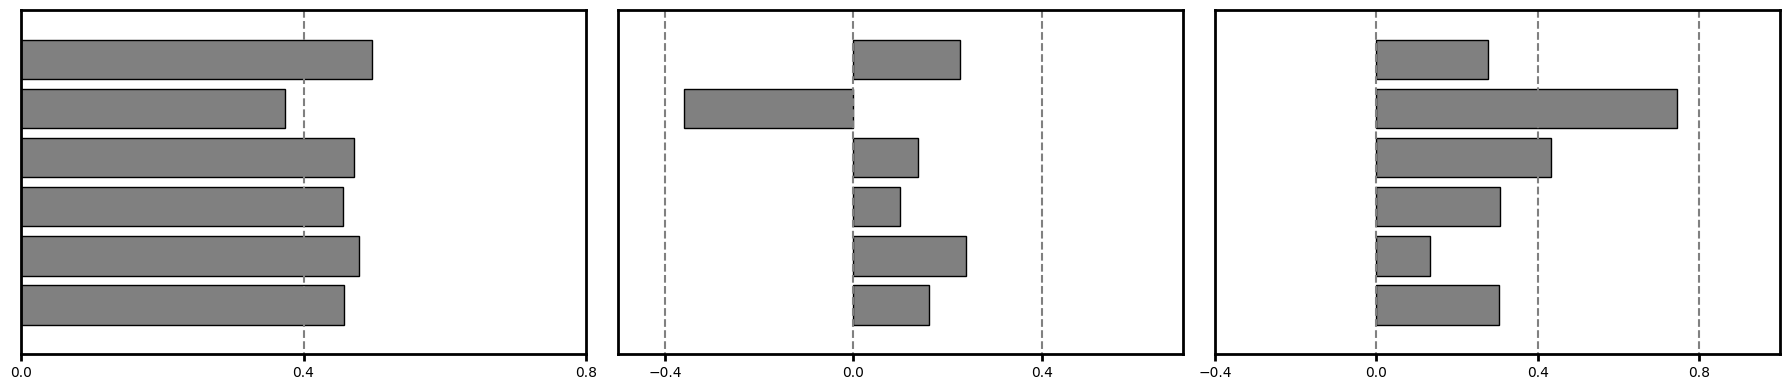

In [23]:
# Extended Data Figure 2b
# PLS coefs
fig = plt.figure(figsize=(18,4))

axs1 = fig.add_subplot(1,3,1)
means = np.mean(coefs, axis=0)[:,0]
axs1.barh(np.arange(6), means, color = 'grey', edgecolor = 'k', zorder = 1)
axs1.set_xticks([0,0.4, 0.8])
axs1.set_yticks([])
axs1.set_xlim([0,0.8])
axs1.set_ylim([-1,6])
axs1.vlines([0, 0.4],-1,6, 'grey', '--')
fig.gca().invert_yaxis()

axs2 = fig.add_subplot(1,3,2)
means = np.mean(coefs, axis=0)[:,1]
axs2.barh(np.arange(6), means, color = 'grey', edgecolor = 'k', zorder = 1)
axs2.set_xticks([-0.4,0,0.4,0.8])
axs2.set_yticks([])
axs2.set_yticklabels([])
axs2.set_xlim([-0.5,0.7])
axs2.set_ylim([-1,6])
axs2.vlines([-0.4,0,0.4,0.8],-1,6, 'grey', '--')
fig.gca().invert_yaxis()

axs3 = fig.add_subplot(1,3,3)
means = np.mean(coefs, axis=0)[:,2]
axs3.barh(np.arange(6), means, color = 'grey', edgecolor = 'k', zorder = 1)
axs3.set_xticks([-0.8,-0.4,0,0.4,0.8])
axs3.set_yticks([])
axs3.set_yticklabels([])
axs3.set_xlim([-0.4,1.0])
axs3.set_ylim([-1,6])
axs3.vlines([-0.8,-0.4,0,0.4,0.8],-1,6, 'grey', '--')
fig.gca().invert_yaxis()
fig.tight_layout()

In [ ]:
# Reciprocity
def calculate_reciprocity(w):
    s_rec = []
    s_out = []
    s_in = []
    for i in range(6):
        w_rec = []
        w_out = []
        w_in = []
        for j in range(6):
            if i != j:
                # if not (i == 0 and j == 5) and not (i == 5 and j == 0) and not (i == 4 and j == 5) and not (i == 5 and j == 4):
                w_rec.append(np.min([w[i,j], w[j,i]]))
                w_out.append(w[i,j])
                w_in.append(w[j,i])
        s_rec.append(np.sum(w_rec))
        s_out.append(np.sum(w_out))
        s_in.append(np.sum(w_in))

    s_rec = np.array(s_rec, dtype=float)
    s_out = np.array(s_out, dtype=float)
    s_in  = np.array(s_in,  dtype=float)
    r_out = np.divide(s_rec, s_out, out=np.zeros_like(s_out), where=s_out > 0)
    r_in  = np.divide(s_rec, s_in,  out=np.zeros_like(s_in),  where=s_in  > 0)
    r_sym  = np.divide(2*s_rec, s_out + s_in,
                       out=np.zeros_like(s_rec), where=(s_out + s_in)>0)
    r_node = 0.5 * (r_out + r_in)

    W_rec = np.sum(s_rec)
    W = np.sum(s_out)  # == np.sum(s_in) == w.sum()
    R = 0.0 if W == 0 else W_rec / W  # Squartini r = W</W

    in_out_ratio = np.log(np.divide(s_in, s_out, out=np.zeros_like(s_in), where=s_out > 0))

    return R, r_sym, in_out_ratio

def local_clustering_fagiolo(A):
    """
    Fagiolo (2007) weighted directed local clustering per node.
    A: (n x n) directed weighted adjacency (self-loop=0)
    반환: 길이 n의 node별 C_i^w
    """
    W = np.asarray(A, float).copy()
    np.fill_diagonal(W, 0.0)
    n = W.shape[0]

    # 가중치 정규화 (최대값으로 나눔; 0이면 그대로)
    wmax = W.max()
    Wn = W / wmax if wmax > 0 else W.copy()

    # 1/3 제곱(가중 삼각형에서 기하평균 구현)
    W13 = np.power(Wn, 1/3.0)
    S = W13 + W13.T

    # 가중 삼각형 수: t_i^w = 0.5 * diag( S @ S @ S )
    T = S @ S @ S
    t = np.diag(T) / 2.0

    # 이진 인접행렬과 차수/상호 엣지 수
    A_bin = (W > 0).astype(int)
    k_out = A_bin.sum(axis=1)
    k_in  = A_bin.sum(axis=0)
    k_tot = k_out + k_in
    m_i   = (A_bin & A_bin.T).sum(axis=1)   # i의 상호 엣지 수

    denom = k_tot*(k_tot - 1) - 2*m_i
    C = np.zeros(n, float)
    mask = denom > 0
    C[mask] = t[mask] / denom[mask]
    return C

In [98]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
Rs_tot = []
r_nodes_tot = []
for dim in range(3):
    Rs = []
    r_nodes = []
    for s in range(28):
        w = latent_reps[s][dim].copy()
        # w = np.arctan(latent_reps[s][dim])
        
        mms1 = MinMaxScaler(feature_range=(0.001,1)).fit(w[aa].reshape(-1,1))
        minmax = mms1.transform(w[aa].reshape(-1,1))[:,0]
        w = np.zeros((6,6))
        w[aa] = minmax
        
        R, r_sym, in_out_ratio = calculate_reciprocity(w)
        Rs.append(R)
        r_nodes.append(r_sym)
    Rs_tot.append(Rs)
    r_nodes_tot.append(r_nodes)
Rs_tot = np.array(Rs_tot)
r_nodes_tot = np.array(r_nodes_tot)

In [99]:
np.mean(Rs_tot, axis=1)

array([0.90266729, 0.87857866, 0.86265089])

In [101]:
ttest_rel(Rs_tot[0], Rs_tot[2], alternative='greater')

TtestResult(statistic=11.146916937825525, pvalue=6.577850799971748e-12, df=27)

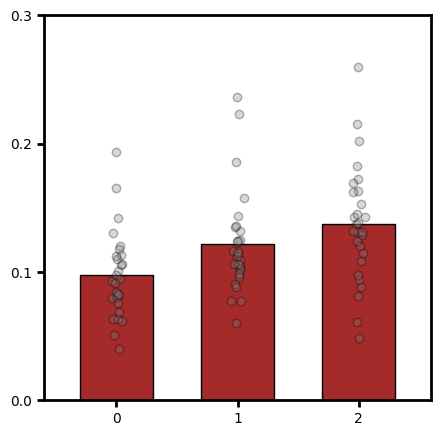

In [ ]:
# Extended Data Figure 2c
plt.figure(figsize=[5, 5])
plt.bar(np.arange(3), np.mean(1 - Rs_tot, axis=1), color = 'brown', edgecolor = 'k', width = 0.6)

for sc in range(3):
    plt.scatter(np.random.normal(size = 28)/40 + sc, 1 - Rs_tot[sc], color = 'grey', edgecolor = 'k', alpha = 0.3)
plt.xticks([0,1,2])
plt.yticks([0,0.1,0.2,0.3])
plt.xlim([-0.6,2.6])
plt.ylim([0,0.3])

In [148]:
np.mean(Rs_tot, axis=1)

array([0.90266729, 0.87857866, 0.86265089])

In [142]:
ttest_rel(Rs_tot[1], Rs_tot[2])

TtestResult(statistic=2.0439495907719762, pvalue=0.05082532746548518, df=27)